# Q-Networks for Hexagon Chess

## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
from engines.environment import HexChessEnv
from engines.qnetworks import QNetworkAgent, QLearning
from hexchess.players import RandomPlayer

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


2024-02-28 09:57:26.188209: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 09:57:26.400663: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 09:57:26.400713: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 09:57:26.401962: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 09:57:26.496359: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 09:57:26.497747: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [4]:
import tensorflow.keras as krs
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


## The environment

In [5]:
# Teach Q networks to play against a random agent playing white
opponent_class = RandomPlayer
opponent_is_white = True
env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=False)

In [6]:
env.render()

     B K N R P * 
    Q B * * P * * 
   N * B * P * * * 
  R * * * P * * * * 
 P P P P P * * * * * 
* * * * * * * * * * * 
 * * * * * P P P P P 
  * * * * P * * * R 
   * * * P * B * N 
    * * P * * B K 
     * P R N Q B 


## The Agent

In [7]:
agent = QNetworkAgent(discount_factor=0.1, learning_rate=1e-2)

2024-02-27 23:00:59.353564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 23:00:59.354162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-27 23:00:59.355901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-27 23:00:59.357574: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at 

In [8]:
agent.fix_model()
agent.model_fixed.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 11, 11, 6)         330       
                                                                 
 up_sampling2d (UpSampling2D  (None, 33, 33, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 33, 3)         165       
                                                                 
 up_sampling2d_1 (UpSampling  (None, 99, 99, 3)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 95, 95, 1)         76        
                                                                 
 conv2d_3 (Conv2D)           (None, 91, 91, 1)         2

## Learn

In [9]:
# Learning configuration
n_episodes = 750
model_fix_episodes = 10
max_episode_length = 50
batch_size = 512
memory_size = batch_size * 4

In [10]:
q_learning = QLearning(agent, env, memory_size=memory_size)

In [11]:
episode_rewards, step_rewards = q_learning.learn(
    n_episodes=n_episodes,
    model_fix_episodes=model_fix_episodes,
    max_episode_length=max_episode_length,
    batch_size=batch_size,
)

2024-02-27 23:01:01.258015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2024-02-27 23:01:03.626523: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fc8aeeaa2d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-27 23:01:03.626561: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-02-27 23:01:03.696296: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episodes 0 - 10: Mean reward 13.9
Episodes 10 - 20: Mean reward 23.9
Episodes 20 - 30: Mean reward 17.8
Episodes 30 - 40: Mean reward 30.6
Episodes 40 - 50: Mean reward 27.2
Episodes 50 - 60: Mean reward 20.6
Episodes 60 - 70: Mean reward 21.9
Episodes 70 - 80: Mean reward 12.5
Episodes 80 - 90: Mean reward 21.5
Episodes 90 - 100: Mean reward 25.9
Episodes 100 - 110: Mean reward 17.0
Episodes 110 - 120: Mean reward 17.1
Episodes 120 - 130: Mean reward 21.4
Episodes 130 - 140: Mean reward 19.4
Episodes 140 - 150: Mean reward 23.0
Episodes 150 - 160: Mean reward 41.9
Episodes 160 - 170: Mean reward 29.8
Episodes 170 - 180: Mean reward 31.5
Episodes 180 - 190: Mean reward 28.8
Episodes 190 - 200: Mean reward 35.1
Episodes 200 - 210: Mean reward 28.3
Episodes 210 - 220: Mean reward 37.2
Episodes 220 - 230: Mean reward 30.7
Episodes 230 - 240: Mean reward 18.0
Episodes 240 - 250: Mean reward 24.4
Episodes 250 - 260: Mean reward 34.8
Episodes 260 - 270: Mean reward 34.6
Episodes 270 - 280: M

### Save results

In [12]:
# Save results
base_path = "./assets/qnetworks/random_pr_"
#krs.saving.save_model(agent.model, f"{base_path}model.keras")
agent.model.save(f"{base_path}model.keras")
np.savetxt(f"{base_path}episode_rewards.csv", episode_rewards, delimiter=",")
np.savetxt(f"{base_path}step_rewards.csv", step_rewards, delimiter=",")

### Visualize Results

In [34]:
# Load results
base_name = "greedy_nr_"
base_path = f"./assets/qnetworks/{base_name}"
episode_rewards = np.loadtxt(f"{base_path}episode_rewards.csv", delimiter=",")
step_rewards = np.loadtxt(f"{base_path}step_rewards.csv", delimiter=",")

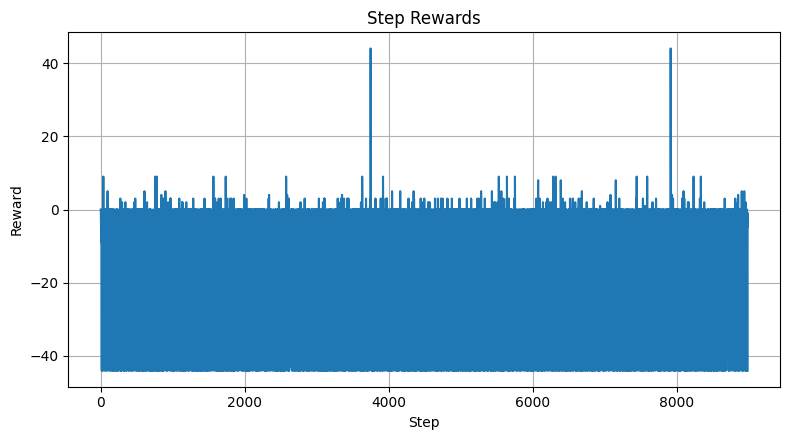

In [35]:
# Plot step rewards
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(step_rewards)
ax.set_xlabel("Step")
ax.set_ylabel("Reward")
ax.set_title("Step Rewards")
ax.grid(True)
fig.tight_layout()
fig.savefig(f"./figures/qnetworks/{base_name}step_rewards.png", dpi=300, facecolor="white")
plt.show()

In [36]:
# Smooth step rewards
kernel_size = 250
kernel = np.ones(kernel_size) / kernel_size
step_rewards_smooth = np.convolve(step_rewards, kernel, mode="same")

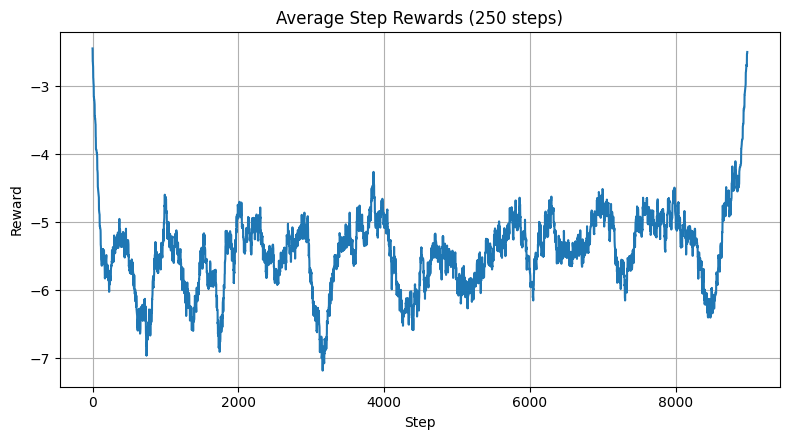

In [37]:
# Plot smooth step rewards
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(step_rewards_smooth)
ax.set_xlabel("Step")
ax.set_ylabel("Reward")
ax.set_title(f"Average Step Rewards ({kernel_size} steps)")
ax.grid(True)
fig.tight_layout()
fig.savefig(f"./figures/qnetworks/{base_name}step_rewards_smooth{kernel_size}.png", dpi=300, facecolor="white")
plt.show()

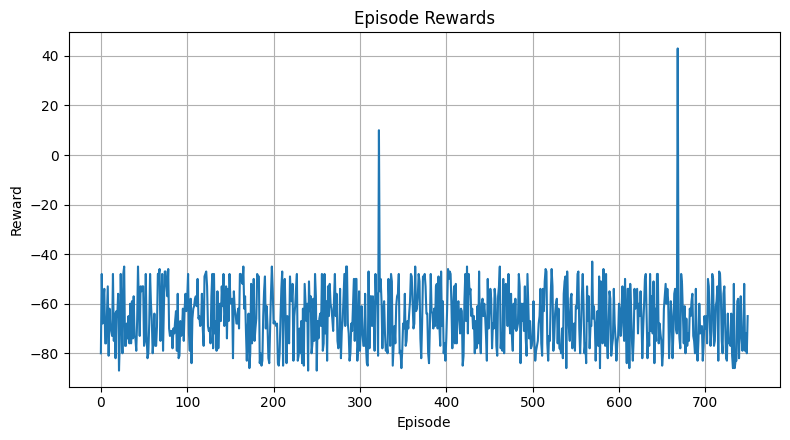

In [38]:
# Plot episode remwards
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(episode_rewards)
ax.set_xlabel("Episode")
ax.set_ylabel("Reward")
ax.set_title("Episode Rewards")
ax.grid(True)
fig.tight_layout()
fig.savefig(f"./figures/qnetworks/{base_name}episode_rewards.png", dpi=300, facecolor="white")
plt.show()

In [39]:
# Smooth episode rewards
kernel_size = 20
kernel = np.ones(kernel_size) / kernel_size
episode_rewards_smooth = np.convolve(episode_rewards, kernel, mode="same")

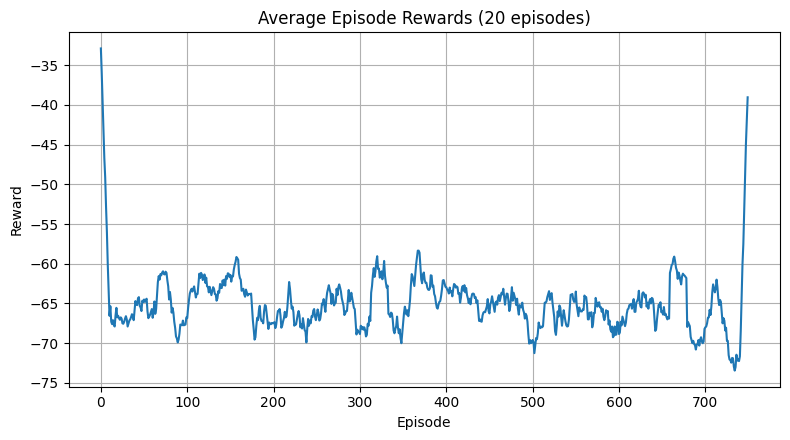

In [40]:
# Plot smooth episode remwards
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(episode_rewards_smooth)
ax.set_xlabel("Episode")
ax.set_ylabel("Reward")
ax.set_title(f"Average Episode Rewards ({kernel_size} episodes)")
ax.grid(True)
fig.tight_layout()
fig.savefig(f"./figures/qnetworks/{base_name}episode_rewards_smooth{kernel_size}.png", dpi=300, facecolor="white")
plt.show()